Epoch 0, Loss: 0.16996583342552185
Epoch 100, Loss: 57.71023178100586
Epoch 200, Loss: 40.10523986816406


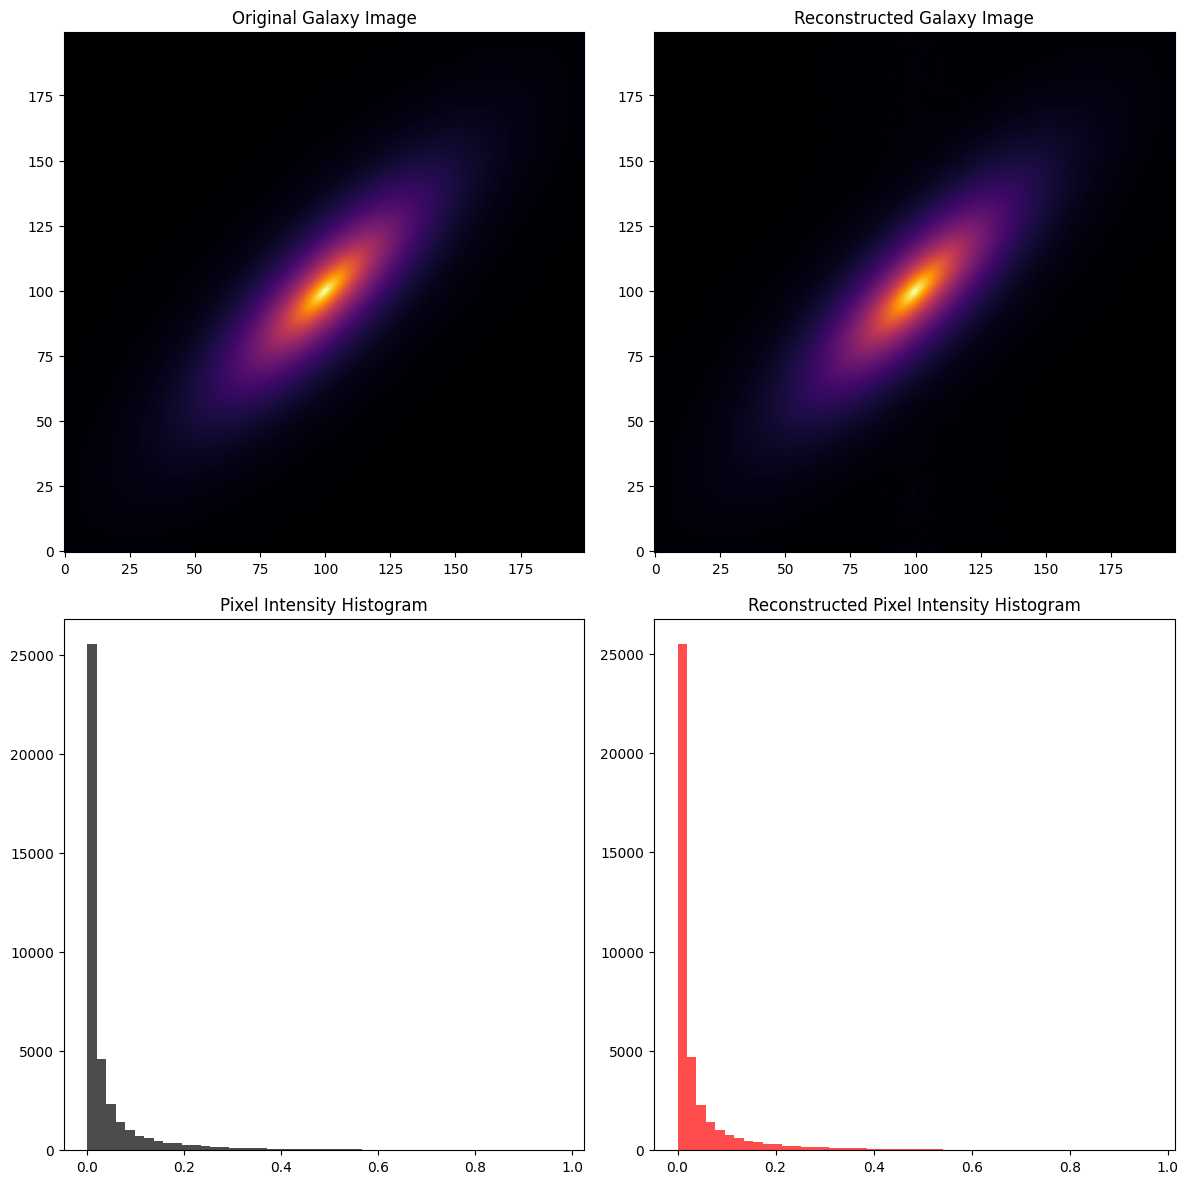

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Function to generate an exponential disk model for a galaxy
def generate_exponential_disk(image_size=200, scale_length_x=30, scale_length_y=10, intensity=1.0, rotation_angle=45):
    """
    Generates an elliptical exponential disk galaxy image with an adjustable ellipticity and rotation.
    
    - scale_length_x: Decay scale along major axis
    - scale_length_y: Decay scale along minor axis
    - rotation_angle: Rotation angle in degrees
    """
    x = np.linspace(-image_size // 2, image_size // 2, image_size)
    y = np.linspace(-image_size // 2, image_size // 2, image_size)
    X, Y = np.meshgrid(x, y)

    # Convert rotation angle to radians
    theta = np.radians(rotation_angle)

    # Rotate coordinates to align with the elliptical axes
    X_rot = X * np.cos(theta) + Y * np.sin(theta)
    Y_rot = -X * np.sin(theta) + Y * np.cos(theta)

    # Apply different scale lengths for major (X_rot) and minor (Y_rot) axes
    R = np.sqrt((X_rot / scale_length_x) ** 2 + (Y_rot / scale_length_y) ** 2)

    # Exponential intensity profile with enhanced ellipticity
    disk = intensity * np.exp(-R)

    return disk

# Function to visualize images, histograms, and spectra
def compare_galaxy_images(original, reconstructed):
    """
    Plots original and reconstructed images with intensity histograms and power spectra.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Display the original and reconstructed images
    axes[0, 0].imshow(original, cmap='inferno', origin='lower')
    axes[0, 0].set_title("Original Galaxy Image")
    
    axes[0, 1].imshow(reconstructed, cmap='inferno', origin='lower')
    axes[0, 1].set_title("Reconstructed Galaxy Image")
    
    # Intensity histograms
    axes[1, 0].hist(original.flatten(), bins=50, color='black', alpha=0.7, label="Original")
    axes[1, 0].set_title("Pixel Intensity Histogram")
    
    axes[1, 1].hist(reconstructed.flatten(), bins=50, color='red', alpha=0.7, label="Reconstructed")
    axes[1, 1].set_title("Reconstructed Pixel Intensity Histogram")


    plt.tight_layout()
    plt.show()

# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2_mu = nn.Linear(128, latent_dim)
        self.fc2_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence / x.shape[0]

# Generate the synthetic galaxy using an exponential disk profile
image = generate_exponential_disk()

# Normalize the image for training
scaler = MinMaxScaler()
image_scaled = scaler.fit_transform(image)

# Convert to PyTorch tensor
image_tensor = torch.tensor(image_scaled, dtype=torch.float32).view(1, -1)

# Define VAE model
input_dim = image_tensor.shape[1]
latent_dim = 2
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.005)

# Train the VAE
epochs = 201
for epoch in range(epochs):
    optimizer.zero_grad()
    recon_image, mu, logvar = vae(image_tensor)
    loss = vae_loss(recon_image, image_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Reconstruct image from trained VAE
reconstructed = vae(image_tensor)[0].detach().numpy().reshape(200, 200)
reconstructed = scaler.inverse_transform(reconstructed)

# Compare original and reconstructed galaxy images
compare_galaxy_images(image, reconstructed)


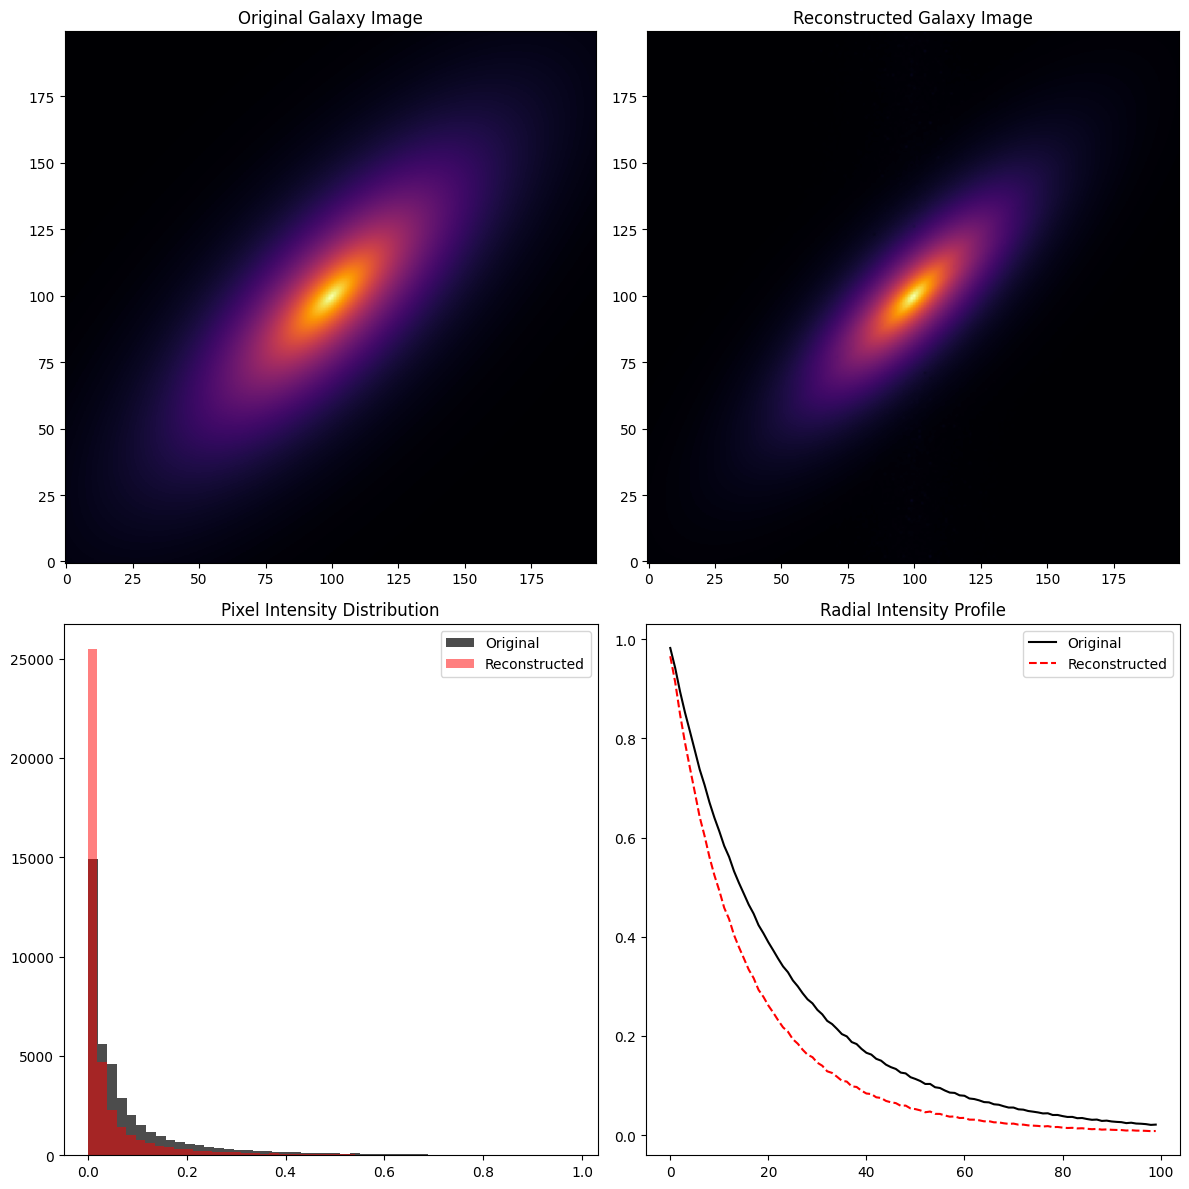

In [13]:
def compute_radial_profile(image):
    """
    Computes the radial intensity profile of an image by averaging pixel values at the same radius.
    """
    image_size = image.shape[0]
    y, x = np.indices((image_size, image_size))
    center = image_size // 2
    r = np.sqrt((x - center) ** 2 + (y - center) ** 2)
    
    # Bin the pixels by radius
    r_bins = np.arange(0, center, 1)
    radial_profile = np.array([image[(r >= r_min) & (r < r_min+1)].mean() for r_min in r_bins])
    
    return r_bins, radial_profile

def compare_galaxy_distributions(original, reconstructed):
    """
    Compares the distributions of pixel intensities, radial intensity profiles, 
    and power spectra between the original and reconstructed images.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # (1) Display the original and reconstructed images
    axes[0, 0].imshow(original, cmap='inferno', origin='lower')
    axes[0, 0].set_title("Original Galaxy Image")
    
    axes[0, 1].imshow(reconstructed, cmap='inferno', origin='lower')
    axes[0, 1].set_title("Reconstructed Galaxy Image")
    
    # (2) Pixel Intensity Histograms
    axes[1, 0].hist(original.flatten(), bins=50, color='black', alpha=0.7, label="Original")
    axes[1, 0].hist(reconstructed.flatten(), bins=50, color='red', alpha=0.5, label="Reconstructed")
    axes[1, 0].set_title("Pixel Intensity Distribution")
    axes[1, 0].legend()

    # (3) Radial Intensity Profiles
    r_original, profile_original = compute_radial_profile(original)
    r_reconstructed, profile_reconstructed = compute_radial_profile(reconstructed)

    axes[1, 1].plot(r_original, profile_original, label="Original", color='black')
    axes[1, 1].plot(r_reconstructed, profile_reconstructed, label="Reconstructed", linestyle='dashed', color='red')
    axes[1, 1].set_title("Radial Intensity Profile")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Example Usage (Assuming you have original and reconstructed images)
original = generate_exponential_disk(scale_length_x=40, scale_length_y=15, rotation_angle=45)
reconstructed = vae(image_tensor)[0].detach().numpy().reshape(200, 200)
reconstructed = scaler.inverse_transform(reconstructed)

compare_galaxy_distributions(original, reconstructed)


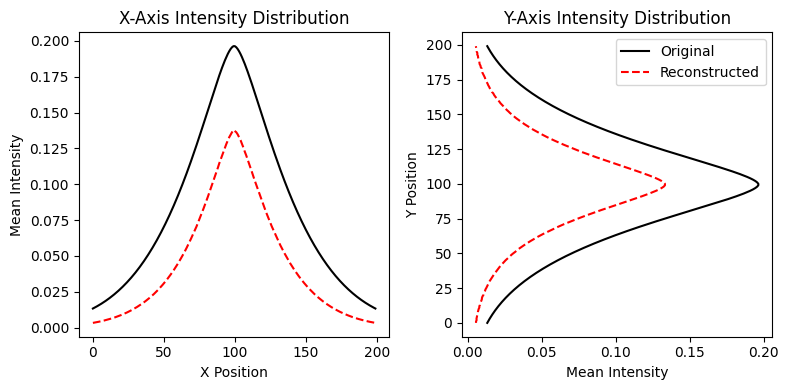

In [14]:
def compare_xy_intensity_distributions(original, reconstructed):
    """
    Compares intensity distributions along the X and Y axes for the original 
    and reconstructed images.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Compute mean intensity along each axis
    original_x_profile = np.mean(original, axis=0)  # Mean intensity along Y-axis
    reconstructed_x_profile = np.mean(reconstructed, axis=0)

    original_y_profile = np.mean(original, axis=1)  # Mean intensity along X-axis
    reconstructed_y_profile = np.mean(reconstructed, axis=1)

    # X-axis intensity distribution
    axes[0].plot(original_x_profile, label="Original", color='black')
    axes[0].plot(reconstructed_x_profile, label="Reconstructed", linestyle='dashed', color='red')
    axes[0].set_title("X-Axis Intensity Distribution")
    axes[0].set_xlabel("X Position")
    axes[0].set_ylabel("Mean Intensity")


    # Y-axis intensity distribution
    axes[1].plot(original_y_profile, np.arange(len(original_y_profile)), label="Original", color='black')
    axes[1].plot(reconstructed_y_profile, np.arange(len(reconstructed_y_profile)), label="Reconstructed", linestyle='dashed', color='red')
    axes[1].set_title("Y-Axis Intensity Distribution")
    axes[1].set_xlabel("Mean Intensity")
    axes[1].set_ylabel("Y Position")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
# Example Usage (assuming original and reconstructed images are available)
compare_xy_intensity_distributions(original, reconstructed)